In [1]:
from IPython.display import HTML, Image
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.eval_measures as eval_measures
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../utils')))
import _utils as utils
%matplotlib inline
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

# Week 11: More Regression

# Regression

* Last week, we looked at year-over-year average stock prices for Apple as a means of running a continuous regression, with a continuous predictor value of 'the number of years after 1995' and a response variable of the stock price.

# Regression

* First we tried making a linear fit:

In [2]:
#Read in Apple Dataset
prices = pd.read_csv('data/AAPL.csv')
prices['Date'] = pd.to_datetime(prices['Date'])
prices['Date'] = prices['Date'].dt.year
year_prices = prices.groupby('Date')['Close'].mean().reset_index()
year_prices = year_prices.rename(columns={'Close': 'Avg_Price'})
year_prices = year_prices[year_prices['Date'] >= 1995].reset_index(drop=True)
year_prices['Years_Since_1995'] = year_prices['Date'] - 1995
mask = year_prices[year_prices['Date'] >= 2010].index
year_prices['This_Decade'] = 0
year_prices['This_Decade'][mask] = 1
year_prices = year_prices[['Years_Since_1995', 'Avg_Price', 'This_Decade']]
year_prices[['Years_Since_1995', 'Avg_Price']].head()

/Users/evanagovino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,Years_Since_1995,Avg_Price
0,0,1.407552
1,1,0.856027
2,2,0.618583
3,3,1.089472
4,4,2.123140


In [3]:
#Without Transformation
apple_slope, apple_intercept, apple_predictions, apple_residuals = utils.evaluate_linear_relationship(year_prices['Years_Since_1995'], year_prices['Avg_Price'])

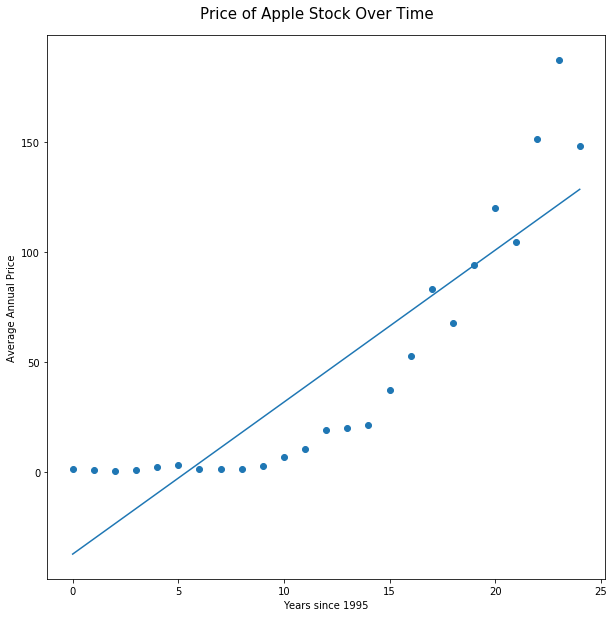

In [4]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Years_Since_1995'], year_prices['Avg_Price'])
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['Years_Since_1995'][sorted_order], apple_predictions[sorted_order])
plt.xlabel('Years since 1995')
plt.ylabel('Average Annual Price')
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

# Regression

* And then we transformed the response variable by taking the log of it so that the relationship became more linear.

In [5]:
apple_log_slope, apple_log_intercept, apple_log_predictions, apple_log_residuals = utils.evaluate_linear_relationship(year_prices['Years_Since_1995'], np.log(year_prices['Avg_Price']))

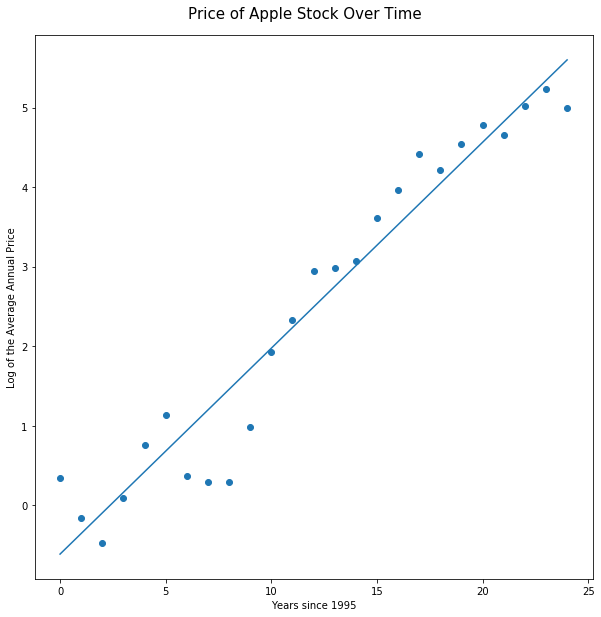

In [6]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Years_Since_1995'], np.log(year_prices['Avg_Price']))
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['Years_Since_1995'][sorted_order], apple_log_predictions[sorted_order])
plt.xlabel('Years since 1995')
plt.ylabel('Log of the Average Annual Price')
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

# Regression

* While regression is extraordinarily useful for **continuous predictors**, it can also be used for **categorical predictors**.
* We will do this by using **one-hot encoding**, which is where we take any data points that have a certain category and mark them with a **1**, while data points that do not have that category will be marked with a **0**.

# Categorical Predictor

* As an example, we can look at our Apple dataset and mark any data points from this decade (2010 and on) with a 1, and any data points not from this decade with a 0.
* We can then run a regression on this like we would for the continuous variable.

In [7]:
#This Decade
year_prices[year_prices['This_Decade'] == 1]

,Years_Since_1995,Avg_Price,This_Decade
15,15,37.142501,1
16,16,52.658095,1
17,17,83.333929,1
18,18,67.677142,1
19,19,93.932142,1
20,20,119.874168,1
21,21,104.621666,1
22,22,151.616665,1
23,23,187.450832,1
24,24,148.259995,1


In [8]:
#Not This Decade
year_prices[year_prices['This_Decade'] == 0]

,Years_Since_1995,Avg_Price,This_Decade
0,0,1.407552,0
1,1,0.856027,0
2,2,0.618583,0
3,3,1.089472,0
4,4,2.123140,0
5,5,3.106771,0
6,6,1.453839,0
7,7,1.343988,0
8,8,1.335238,0
9,9,2.674583,0


# Categorical Predictor

* Here the intercept is the value of Apple stock when it is not 0, which is predicted to be 6.
* And the slope is the intercept plus the value of the Apple stock when it is 1, which is predicted to be 6 + 98, or 104.

In [9]:
#Without Transformation
apple_decade_slope, apple_decade_intercept, apple_decade_predictions, apple_decade_residuals = utils.evaluate_linear_relationship(year_prices['This_Decade'], year_prices['Avg_Price'])
print('Intercept:', apple_decade_intercept)
print('Slope:', apple_decade_slope)

Intercept: 6.233398572222214
Slope: 98.42331502777778


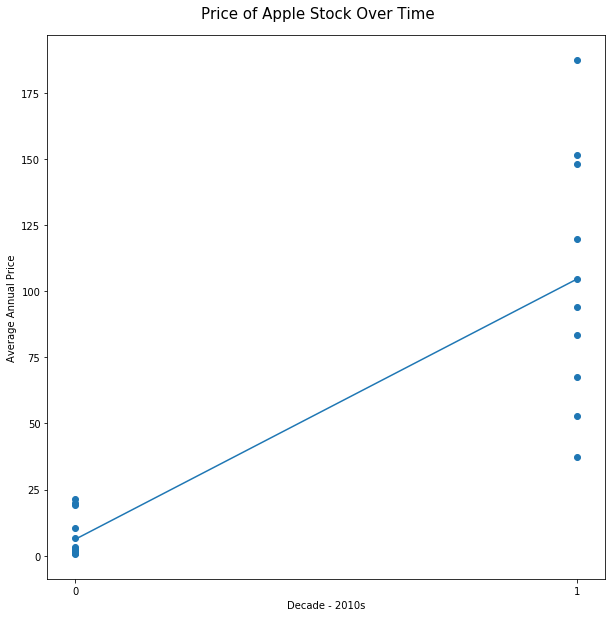

In [10]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['This_Decade'], year_prices['Avg_Price'])
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['This_Decade'][sorted_order], apple_decade_predictions[sorted_order])
plt.xlabel('Decade - 2010s')
plt.ylabel('Average Annual Price')
plt.xticks([0,1])
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

These two values have a **correlation** of 0.85 and even an **R-squared value** of 0.73, meaning that looking at only whether or not we're in this decade, regardless of the specific year, can explain a lot of the change in price in Apple Stock.

In [11]:
print('Correlation:', np.round(stats.pearsonr(year_prices['This_Decade'], year_prices['Avg_Price'])[0], 4))
print('R-Squared Value:', np.round(utils.get_r2(apple_decade_predictions, year_prices['Avg_Price']), 4))

Correlation: 0.8559
R-Squared Value: 0.7326


# Residuals

* Of course we'll still want to validate our linear assumptions like we would for a continuous predictor.

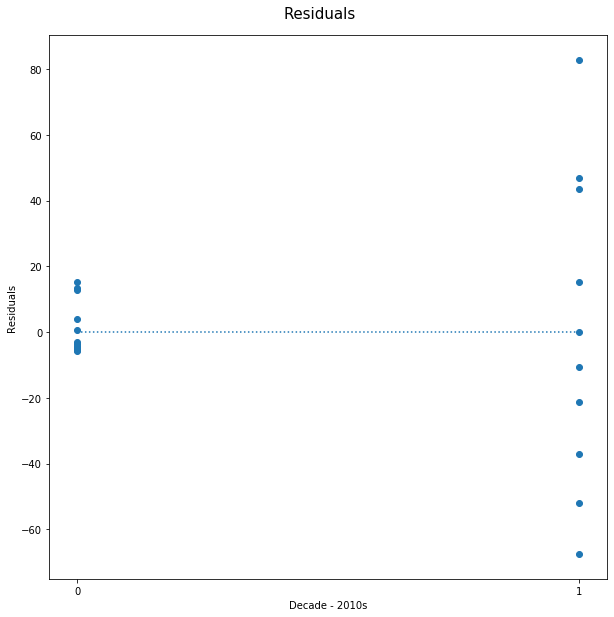

In [12]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['This_Decade'], apple_decade_residuals)
plt.plot([0, year_prices['This_Decade'].max()], [0,0], linestyle='dotted')
plt.xlabel('Decade - 2010s')
plt.ylabel('Residuals')
plt.xticks([0,1])
fig.suptitle('Residuals', fontsize=15, y=0.92)

hide_toggle()

# Residuals

* Here we can see that our residuals are **hetereoskedastic**, as there is much more variance at the 1 value than there is at the 0 value.
* We can address this just like we did with a continuous predictor - by **transforming the response variable**. Here, we'll take the cubed root of the response variable and do a regression on this decade vs. the cubed root of the Apple Stock price.

In [13]:
#With Transformation
apple_slope_cubed_root, apple_intercept_cubed_root, apple_predictions_cubed_root, apple_residuals_cubed_root = utils.evaluate_linear_relationship(year_prices['This_Decade'], np.power(year_prices['Avg_Price'], 1/3))
print('Intercept:', np.round(apple_intercept_cubed_root, 4))
print('Slope:', np.round(apple_slope_cubed_root, 4))

Intercept: 1.5769
Slope: 3.0295


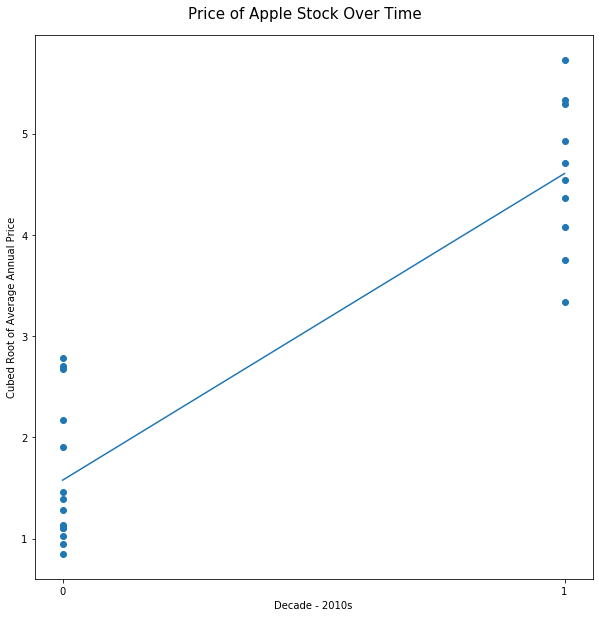

In [14]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['This_Decade'], np.power(year_prices['Avg_Price'], 1/3))
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['This_Decade'][sorted_order], apple_predictions_cubed_root[sorted_order])
plt.xlabel('Decade - 2010s')
plt.ylabel('Cubed Root of Average Annual Price')
plt.xticks([0,1])
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

# Categorical Predictor

* Here we see the correlation and R-squared value go up when we transform the response variable.

In [15]:
print('Correlation:', np.round(stats.pearsonr(year_prices['This_Decade'], np.power(year_prices['Avg_Price'], 1/3))[0], 4))
print('R-Squared Value:', np.round(utils.get_r2(apple_predictions_cubed_root, np.power(year_prices['Avg_Price'], 1/3)), 4))



Correlation: 0.9086
R-Squared Value: 0.8255


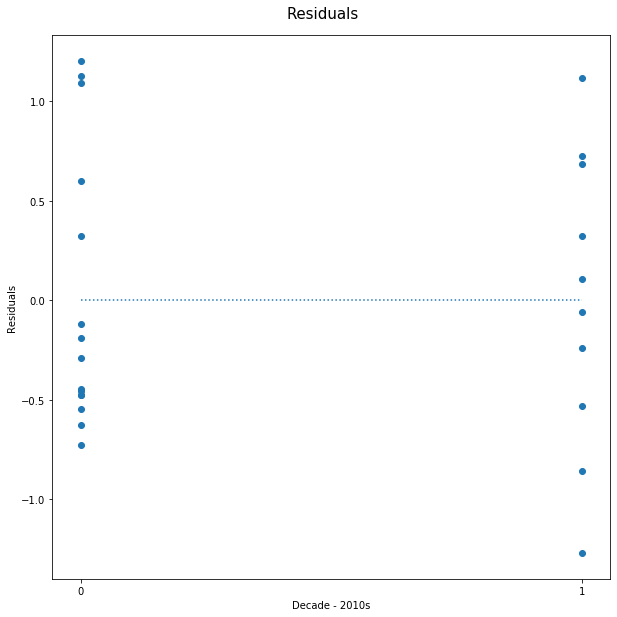

In [16]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['This_Decade'], apple_residuals_cubed_root)
plt.plot([0, year_prices['This_Decade'].max()], [0,0], linestyle='dotted')
plt.xlabel('Decade - 2010s')
plt.ylabel('Residuals')
plt.xticks([0,1])
fig.suptitle('Residuals', fontsize=15, y=0.92)

hide_toggle()

Here, the residuals look much more evenly distributed.

# Polynomial Regression

* So far, we've only worked with transforming the response variable in a regression model.
* Rather than transforming the predictor variable, we can add higher order variables (such as X^^2, X^^3 and so forth) as predictors.
* The catch is that we must include the lower order variables also.
* The mathy details of why this is are beyond the scope of this class, but think of a quadratic equation, where both x^2 and x are included.
* Working with polynomials is called **polynomial regression**, as opposed to **simple linear regression**.

$$
a x^{2}+b x+c=0
$$

# Polynomial Regression

* Let's look back at our Apple stock example, and now run a polynomial regression rather than a linear regression.
* Again, below is the example of using the number of years after 1995 to predict the stock price.

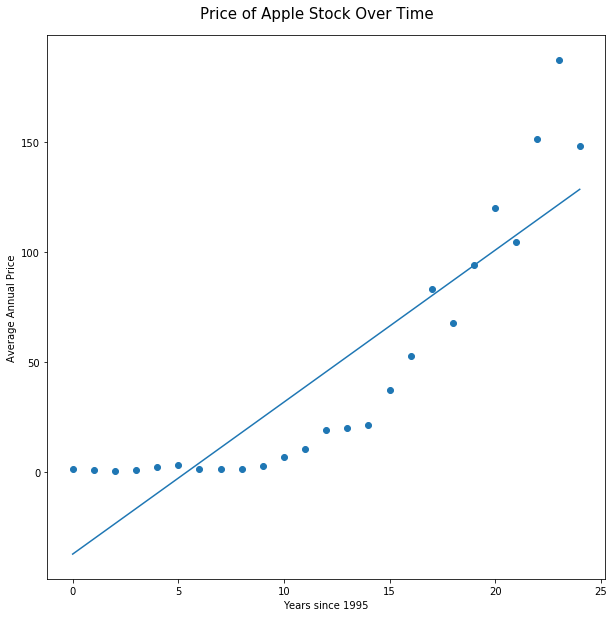

In [17]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Years_Since_1995'], year_prices['Avg_Price'])
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['Years_Since_1995'][sorted_order], apple_predictions[sorted_order])
plt.xlabel('Years since 1995')
plt.ylabel('Average Annual Price')
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

# Polynomial Regression

* The above example is what's known as **underfitting**. The predicted values are not accurately capturing the relationship of the two variables.
* As we've seen, the R-squared value of this relationship is 0.78.
* The RMSE, or **Root Mean Squared Error** of this relationship is 26.2122. The RMSE is scale invariant, much like covariance or variance, but will be a useful metric for comparing the effiacy of our different models, as **R-Squared Does Not Apply to Non-Linear Models**.

In [18]:
print('R-Squared Value:', np.round(utils.get_r2(apple_predictions, year_prices['Avg_Price']), 4))
print('RMSE:', np.round(utils.get_rmse(apple_predictions, year_prices['Avg_Price']), 4))

R-Squared Value: 0.7835
RMSE: 26.2122


# Polynomial Regression

* Let's now fit the second degree polynomial of the number of years since 1995.

In [19]:
second_order_variables = np.polyfit(year_prices['Years_Since_1995'], year_prices['Avg_Price'], 2)
second_order_variables

array([ 0.50862183, -5.29230053,  9.42045142])

Now we will multiply 0.5 * the number of years since 1995 squared, -5.29 * the number of years since 1995, and add a constant of 9.42.

In [20]:
second_order_function = np.poly1d(second_order_variables)
second_order_predictions = second_order_function(year_prices['Years_Since_1995'])

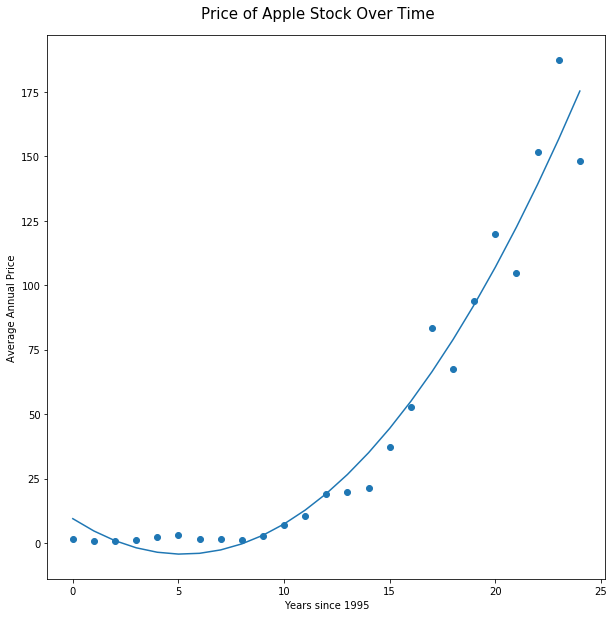

In [21]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Years_Since_1995'], year_prices['Avg_Price'])
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['Years_Since_1995'], second_order_predictions)
plt.xlabel('Years since 1995')
plt.ylabel('Average Annual Price')
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

In [22]:
print('RMSE:', np.round(utils.get_rmse(second_order_predictions, year_prices['Avg_Price']), 4))

RMSE: 11.4087


# Polynomial Regression

* Here we see that this curve fits the data much better, and the corresponding RMSE is much lower.

# Polynomial Regression

* We can try a fourth degree polynomial...

In [23]:
fourth_order_variables = np.polyfit(year_prices['Years_Since_1995'], year_prices['Avg_Price'], 4)
fourth_order_function = np.poly1d(fourth_order_variables)
fourth_order_predictions = fourth_order_function(year_prices['Years_Since_1995'])

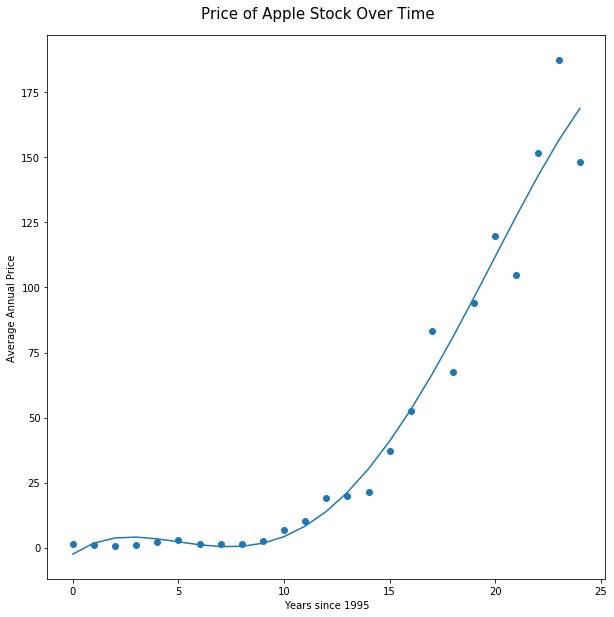

In [24]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Years_Since_1995'], year_prices['Avg_Price'])
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['Years_Since_1995'], fourth_order_predictions)
plt.xlabel('Years since 1995')
plt.ylabel('Average Annual Price')
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

In [25]:
print('RMSE:', np.round(utils.get_rmse(fourth_order_predictions, year_prices['Avg_Price']), 4))

RMSE: 10.3627


# Polynomial Regression

* Or even go crazy and do a twentieth-order polynomial.

In [26]:
twentieth_order_variables = np.polyfit(year_prices['Years_Since_1995'], year_prices['Avg_Price'], 20)
twentieth_order_function = np.poly1d(twentieth_order_variables)
twentieth_order_predictions = twentieth_order_function(year_prices['Years_Since_1995'])

/Users/evanagovino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


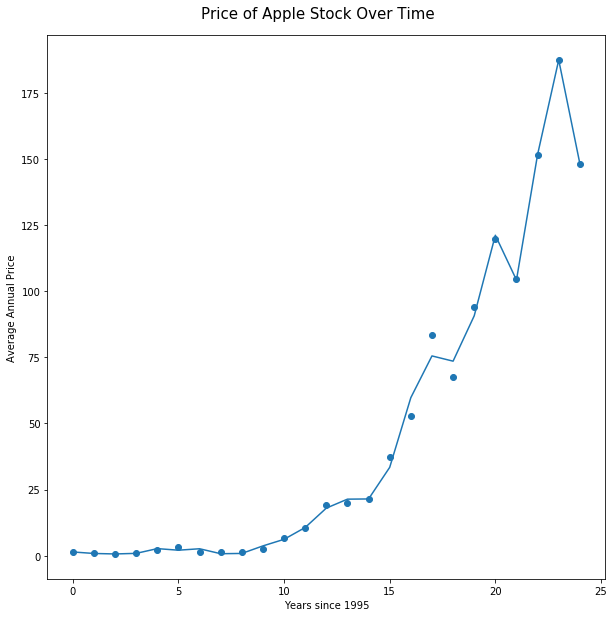

In [27]:
fig = plt.figure(figsize=(10,10))
plt.scatter(year_prices['Years_Since_1995'], year_prices['Avg_Price'])
sorted_order = np.argsort(year_prices['Years_Since_1995'])
plt.plot(year_prices['Years_Since_1995'], twentieth_order_predictions)
plt.xlabel('Years since 1995')
plt.ylabel('Average Annual Price')
fig.suptitle('Price of Apple Stock Over Time', fontsize=15, y=0.92)

hide_toggle()

In [28]:
print('RMSE:', np.round(utils.get_rmse(twentieth_order_predictions, year_prices['Avg_Price']), 4))

RMSE: 2.6892


# Polynomial Regression

* As we increase the number of degrees in our polynomial regression, our predictions fit closer to the data, and our RMSE continues to go down.
* This is a good thing...right?

# Over-Fitting vs. Under-Fitting

* The issue is that as our model gets more and more complex, we will start to **overfit** rather than **underfit** our data.
* A model that **underfits** the data is said to have **high bias**. It is not reliable in predicting new values because it's too simplistic.
* A model that **overfits** the data is said to have **high variance**. It is not reliable in predicting new values because it's fitting too closely to the data.
* Look at the model from before - do we expect that Apple stock will go down next year because it went down the previous year? Or up because it's gone up in several of the previous years?
* The balance between these two extremes is called the **bias-variance tradeoff**.

## Testing vs. Training

* How do we then account for this? Since our RMSE is continuing to go down, we can't use the RMSE of the whole dataset as a way of evaluating the success of our model.
* We can, however, split up our model into **testing** and **training** sets. Typically the training set is at around 80% of the model, while the testing set is the remaining 20% of the model.
* We will **randomly divide** our dataset into these two buckets, train our model on 80% of it, and then see how well it predicts the other 20% of it.

In [29]:
x_train, x_test, y_train, y_test  = utils.get_train_test(year_prices['Years_Since_1995'], year_prices['Avg_Price'])
print('x train_values:', x_train)
print('x test_values:', x_test)
print('y train_values:', y_train)
print('y test_values:', y_test)

x train_values: [ 0  1  2  3  4  5  8  9 11 12 13 15 16 17 18 20 21 22 23 24]
x test_values: [ 6 19 14 10  7]
y train_values: [  1.407552     0.85602683   0.61858258   1.08947183   2.12313992
   3.10677075   1.33523808   2.67458342  10.29190483  19.05047625
  19.78297625  37.14250067  52.658095    83.33392908  67.6771425
 119.87416842 104.62166592 151.6166655  187.45083242 148.259995  ]
y test_values: [ 1.45383933 93.9321415  21.484762    6.88166658  1.34398792]


# Testing vs. Training

* Let's train our model using the 20th degree polynomial on our training data, and see how well it predicts unseen data.

In [ ]:
twentieth_order_variables = np.polyfit(x_train, y_train, 20)
twentieth_order_function = np.poly1d(twentieth_order_variables)
twentieth_order_train_predictions = twentieth_order_function(x_train)
twentieth_order_test_predictions = twentieth_order_function(x_test)

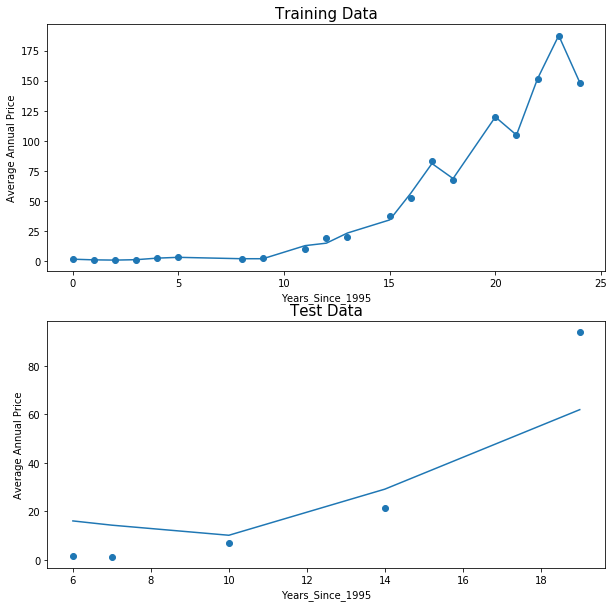

In [31]:
fig, ax=plt.subplots(2,1, figsize=(10,10))
ax[0].scatter(x_train, y_train)
sorted_order = np.argsort(x_train)
ax[0].plot(x_train[sorted_order], twentieth_order_train_predictions[sorted_order])
ax[1].scatter(x_test, y_test)
sorted_order = np.argsort(x_test)
ax[1].plot(x_test[sorted_order], twentieth_order_test_predictions[sorted_order])
ax[0].set_xlabel('Years_Since_1995')
ax[0].set_ylabel('Average Annual Price')
ax[1].set_xlabel('Years_Since_1995')
ax[1].set_ylabel('Average Annual Price')
ax[0].set_title('Training Data', fontsize=15, y=1)
ax[1].set_title('Test Data', fontsize=15, y=1)

hide_toggle()

In [30]:
twentieth_order_variables = np.polyfit(x_train, y_train, 20)
twentieth_order_function = np.poly1d(twentieth_order_variables)
twentieth_order_train_predictions = twentieth_order_function(x_train)
print('RMSE on Training Set:', utils.get_rmse(twentieth_order_train_predictions, y_train))
twentieth_order_test_predictions = twentieth_order_function(x_test)
print('RMSE on Testing Set:', utils.get_rmse(twentieth_order_test_predictions, y_test))

RMSE on Training Set: 1.8174695564517627
RMSE on Testing Set: 17.17533873723673


/Users/evanagovino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


The model clearly does not do a good job of predicting new varaibles, as the RMSE is much higher on the testing set than it is on the training set, and we can see visually that it severaly underfits unseen data while several overfitting the training data.

Let's run a loop on all polynomial values of 1 through 20 and see how what the corresponding RMSE scores are on the training and testing data.

In [32]:
polynomials = []
train_rmse = []
test_rmse = []
for i in range(1, 21):
    polynomials.append(i)
    variables = np.polyfit(x_train, y_train, i)
    function = np.poly1d(variables)
    train_predictions = function(x_train)
    train_rmse.append(utils.get_rmse(train_predictions, y_train))
    test_predictions = function(x_test)
    test_rmse.append(utils.get_rmse(test_predictions, y_test))
df = pd.DataFrame()
df['polynomials'] = polynomials
df['train_rmse'] = train_rmse
df['test_rmse'] = test_rmse

/Users/evanagovino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
/Users/evanagovino/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  


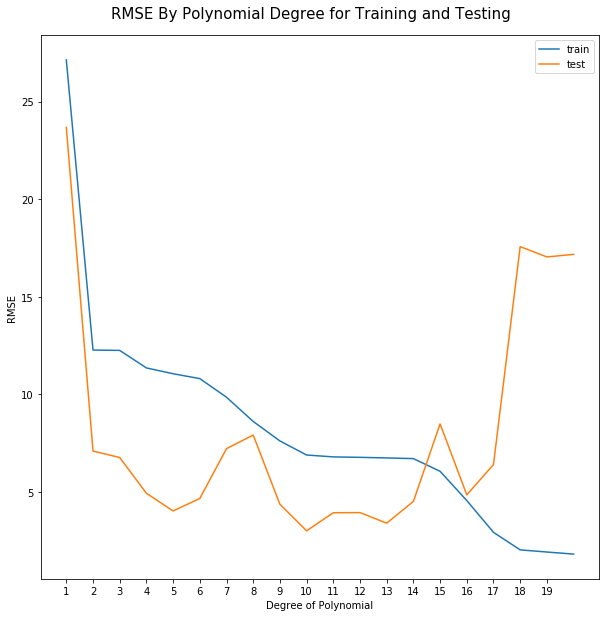

In [33]:
fig = plt.figure(figsize=(10,10))
plt.plot(df['polynomials'], df['train_rmse'], label='train')
plt.plot(df['polynomials'], df['test_rmse'], label='test')
plt.xticks(range(1,20))
plt.xlabel('Degree of Polynomial')
plt.ylabel('RMSE')
fig.suptitle('RMSE By Polynomial Degree for Training and Testing', fontsize=15, y=0.92)
plt.legend()

hide_toggle()

Above is the RMSE of the training data in blue, while the RMSE of the testing data is in orange.

# Evaluating RMSE

* The training RMSE continues to go down as we increase the degree of polynomial, which aligns with what we observed earlier.
* The testing RMSE goes down initially but then oscillates after that, and eventually ends up being higher than the training RMSE.
* You could argue that you could fit the model up to the fifth polynomial, but the second polynomial is probably fine, as most of the reduction in RMSE is between the first and second polynomial.

# Testing vs. Training

* Let's now examine the training and testing plots for data fit on the second degree polynomial.

In [50]:
second_order_variables = np.polyfit(x_train, y_train, 2)
second_order_function = np.poly1d(second_order_variables)
second_order_train_predictions = second_order_function(x_train)
second_order_test_predictions = second_order_function(x_test)

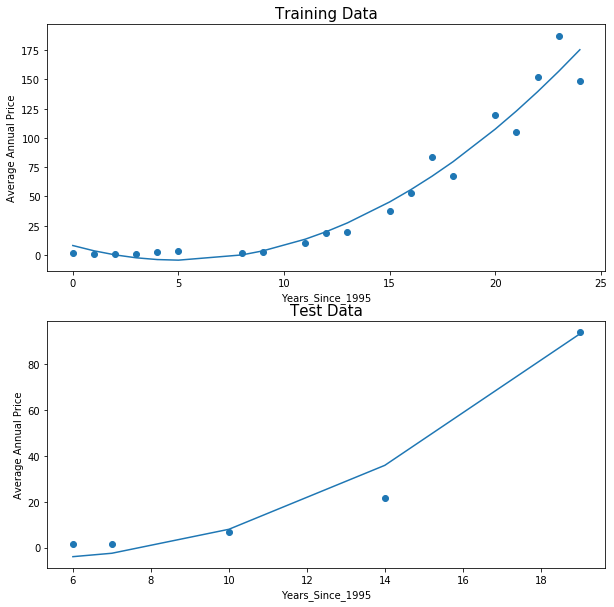

In [51]:
fig, ax=plt.subplots(2,1, figsize=(10,10))
ax[0].scatter(x_train, y_train)
sorted_order = np.argsort(x_train)
ax[0].plot(x_train[sorted_order], second_order_train_predictions[sorted_order])
ax[1].scatter(x_test, y_test)
sorted_order = np.argsort(x_test)
ax[1].plot(x_test[sorted_order], second_order_test_predictions[sorted_order])
ax[0].set_xlabel('Years_Since_1995')
ax[0].set_ylabel('Average Annual Price')
ax[1].set_xlabel('Years_Since_1995')
ax[1].set_ylabel('Average Annual Price')
ax[0].set_title('Training Data', fontsize=15, y=1)
ax[1].set_title('Test Data', fontsize=15, y=1)

hide_toggle()

# Testing vs. Training

* Here we see that the training data is not nearly as overfit, and the testing predictions are more accurate. We can confirm this both visually and by looking at the **Root Mean Squared Error** of the test results for both the second degree fit and the twentieth degree fit.

In [53]:
print('second degree RMSE - test', utils.get_rmse(second_order_test_predictions, y_test))
print('twentieth degree RMSE - test', utils.get_rmse(twentieth_order_test_predictions, y_test))

second degree RMSE - test 7.09787090135728
fifth degree RMSE - test 17.17533873723673


# Multivariate Regression

* Now we can combine our tools to run a multivariate regression, where we can predict a continuous variable using a combination of other continuous variables and categorical variables.
* Fortunately the execution of this is not cumbersome with the use of the **statsmodels** package.
* As an example, we can look at a dataset showing credit rating, income, credit limit, and credit card balance for a host of individuals along with several categorical and continuous descriptors of those individuals.

In [37]:
credit = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Credit.csv')
credit.head()

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


# Multivariate Regression

* A **pairplot** is a good tool for evaluating the relationship between several different subsets of variables.
* Note that it only looks at continuous variables.
* If we want to only look at credit card rating as a response variable, we can look at all of the values in the fourth column to look at the relationship between credit card rating and the other continuous variables.

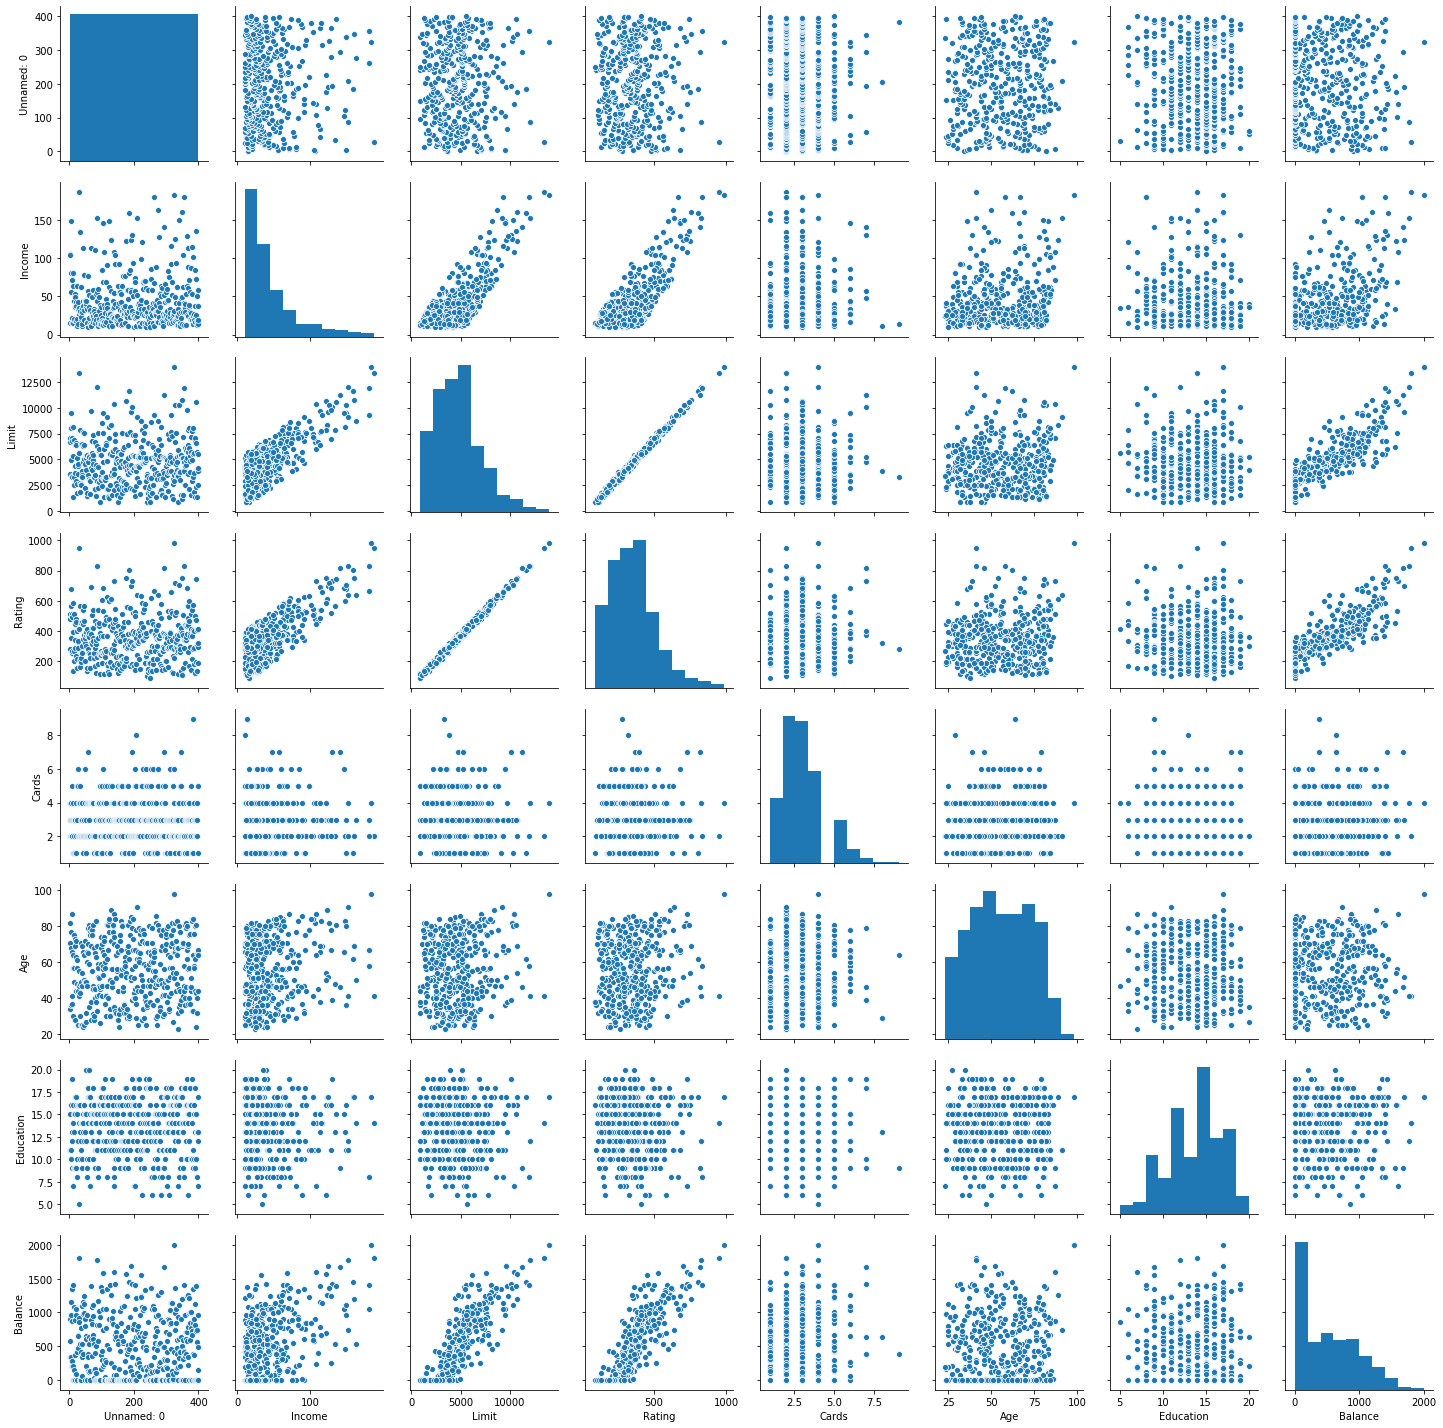

In [38]:
sns.pairplot(credit)

# Multivariate Regression

* An quick look shows that credit rating appears to be heavily correlated with credit limit, and also highly correlated with credit card balance and income. It appears to be less correlated with education and age.
* Let's look at the relationship between **Income** and **Credit Rating**

In [39]:
est = smf.ols('Rating ~ Income', credit).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     667.0
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           4.36e-87
Time:                        22:17:08   Log-Likelihood:                -2386.9
No. Observations:                 400   AIC:                             4778.
Df Residuals:                     398   BIC:                             4786.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    197.8411      7.709     25.664      0.000     182.686     212.996
Income         3.4742      0.135     25.826      0.000       3.210       3.739
==============================================================================
Omnibus:                      157.557   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.450
Skew:                          -0.009   Prob(JB):                     2.20e-05
Kurtosis:                       1.866   Cond. No.                         93.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Regression

* There's a lot here to process but we're already familiar with a lot of these variables. We can see the R-squared variable in the top right, along with the coefficients for the intercept (which is the intercept value) and income (which is the slope value). 
* We can also see the **p-value** of these variables to see whether their coefficients are statistically significant, along with the corresponding **confidence intervals** of these coefficients (think nonrejection region values at 0.025 and 0.975). Essentially if either of these values are negative (because the coefficients are positive - the same would apply for vice versa), that variable will not be statistically significant.
* We don't need to worry about the other metrics noted here for the scope of this class.

The RMSE isn't in the output explicitly, but we can evaluate it as such below:

In [40]:
eval_measures.rmse(est.predict(), credit['Rating'])

94.46883336199913

# Regression

* As a sanity check, we can run our 'evaluate linear relationship' function to confirm that the results we're seeing are the same as what this model is returning to us.

In [41]:
credit_slope, credit_intercept, credit_predictions, credit_residuals = utils.evaluate_linear_relationship(credit['Income'], credit['Rating'])
print('Intercept:', credit_intercept)
print('Slope:', credit_slope)
print('R-Squared Value:', utils.get_r2(credit_predictions, credit['Rating']))
print('RMSE Value:', utils.get_rmse(credit_predictions, credit['Rating']))

Intercept: 197.8411005542829
Slope: 3.474187818777865
R-Squared Value: 0.6262785455281015
RMSE Value: 94.46883336199913


# Regression

* The fun part is that now we can run a multivariate regression using all of the continuous and categorical variables in the dataset.

In [42]:
est = smf.ols('Rating ~ Income + Limit + Cards + Age + Education + Gender + Student + Married + Ethnicity + Balance', credit).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     8399.
Date:                Tue, 19 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:17:08   Log-Likelihood:                -1488.4
No. Observations:                 400   AIC:                             3001.
Df Residuals:                     388   BIC:                             3049.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 32.0084      4.136      7.739      0.000      23.877      40.140
Gender[T.Female]           0.2204      1.020      0.216      0.829      -1.785       2.225
Student[T.Yes]            -2.0068      2.805     -0.715      0.475      -7.522       3.508
Married[T.Yes]             2.3823      1.058      2.251      0.025       0.301       4.463
Ethnicity[T.Asian]        -2.0062      1.449     -1.384      0.167      -4.856       0.843
Ethnicity[T.Caucasian]    -0.3096      1.255     -0.247      0.805      -2.777       2.158
Income                     0.1239      0.047      2.644      0.009       0.032       0.216
Limit                      0.0632      0.001     44.309      0.000       0.060       0.066
Cards                      4.5967      0.391     11.756      0.000       3.828       5.365
Age                        0.0126      0.030      0.415      0.679      -0.047       0.072
Education                 -0.2349      0.164     -1.434      0.152      -0.557       0.087
Balance                    0.0120      0.005      2.315      0.021       0.002       0.022
==============================================================================
Omnibus:                        6.295   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                5.637
Skew:                           0.226   Prob(JB):                       0.0597
Kurtosis:                       2.633   Cond. No.                     4.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Regression

* Now we can see the coefficient values and p-values for all of our predictors, along with the final R-squared value which has gone up to 99.6%.
* Note that the categorical variables have been hot-coded like we discussed, so there are different predictors for each of the different values in these categories (minus one initial value)
* All of these effects show us the 'contribution' of these different predictors, both in their coefficients and p-values. The coefficients show us each variables' independent effect.
* Age for example, has an extremely high p-value, and could probably be removed from the model without it affecting the final R-squared score too much.
* Limit, on the other hand, has a p-value of 0, but an extremely small slope. Every additional dollar on somebody's credit limit leads to an additional 0.06 points on their credit rating.